## Problem Statement

The SaaS company is a **B2B (business-to-business)** organization selling **sales and marketing software** to other companies. They have collected **transactional data** from their customers and have hired a **data scientist** to analyze this dataset in order to gain insights and improve the company’s future performance.

The specific insights required are:

1. **Top 5 Products by Profit Margin:**  
   Identify the 5 products with the highest profit margins to prioritize resource allocation in R&D.

2. **Top 3 Industries by Profit:**  
   Determine the 3 industries that yield the highest profit to focus company efforts on these sectors.

3. **Top 5 Countries by Sales:**  
   Identify the 5 countries with the highest sales to expand the team and networking in those regions.

4. **Quarterly Profit Analysis:**  
   Break down profits by quarter to help plan resource allocation.

5. **Sales vs. Discount Correlation:**  
   Evaluate the correlation between sales and discounts to measure the effectiveness of the discounts provided.

6. **Industry-Country Independence Analysis:**  
   Assess the independence between the 5 countries with the highest sales (from Insight 3) and the 3 industries with the highest profit (from Insight 2) using a **Chi-Squared Test**, to decide whether those 3 industries should be prioritized in those 5 countries.


#**DB Loading**

In [ ]:
!pip install prettytable==3.9.0

  Attempting uninstall: prettytable
    Found existing installation: prettytable 3.16.0
    Uninstalling prettytable-3.16.0:
      Successfully uninstalled prettytable-3.16.0


In [ ]:
#1️⃣
from google.colab import files
import zipfile, os, glob
import pandas as pd
import sqlite3

#2️⃣
# Upload the zip containing Excel files
print("Upload the csv files")
uploaded = files.upload()

Upload the csv files


Saving SaaS_Company.db to SaaS_Company.db


In [ ]:
!ls

SaaS_Company.db  sample_data


In [ ]:
#3️⃣ Read data(csv) and make into dataframe
df = pd.read_csv('SaaS-Sales.csv')
df.head()

,Row ID,Order ID,Order Date,Date Key,Contact Name,Country,City,Region,Subregion,Customer,Customer ID,Industry,Segment,Product,License,Sales,Quantity,Discount,Profit
0,1,EMEA-2022-152156,11/9/2022,20221109,Nathan Bell,Ireland,Dublin,EMEA,UKIR,Chevron,1017,Energy,SMB,Marketing Suite,16GRM07R1K,261.9600,2,0.00,41.9136
1,2,EMEA-2022-152156,11/9/2022,20221109,Nathan Bell,Ireland,Dublin,EMEA,UKIR,Chevron,1017,Energy,SMB,FinanceHub,QLIW57KZUV,731.9400,3,0.00,219.5820
2,3,AMER-2022-138688,6/13/2022,20220613,Deirdre Bailey,United States,New York City,AMER,NAMER,Phillips 66,1056,Energy,Strategic,FinanceHub,JI6BVL70HQ,14.6200,2,0.00,6.8714
3,4,EMEA-2021-108966,10/11/2021,20211011,Zoe Hodges,Germany,Stuttgart,EMEA,EU-WEST,Royal Dutch Shell,1031,Energy,SMB,ContactMatcher,DE9GJKGD44,957.5775,5,0.45,-383.0310
4,5,EMEA-2021-108966,10/11/2021,20211011,Zoe Hodges,Germany,Stuttgart,EMEA,EU-WEST,Royal Dutch Shell,1031,Energy,SMB,Marketing Suite - Gold,OIF7NY23WD,22.3680,2,0.20,2.5164


In [ ]:
#4️⃣
file = "SaaS-Sales.csv"
table_name = os.path.splitext(os.path.basename(file))[0]

In [ ]:
# 5️⃣ Create / connect to SQLite DB
db_name = 'SaaS_Company.db'
conn = sqlite3.connect(db_name)

try:
    # Insert into SQL
    df.to_sql(table_name, conn, if_exists='replace', index=False)
    print(f"✅ Inserted {len(df)} rows into table '{table_name}'")
except Exception as e:
    print(f"❌ Error loading {file}: {e}")

# Commit & close
conn.commit()
conn.close()


✅ Inserted 9994 rows into table 'SaaS-Sales'


In [ ]:
# 6️⃣ Connect with %sql magic
%load_ext sql
%sql sqlite:///SaaS_Company.db
print("\n✅ Setup complete! Use %sql to query your tables.")


✅ Setup complete! Use %sql to query your tables.


In [ ]:
%%sql
ALTER TABLE "SaaS-Sales" RENAME TO SaaS_Sales;

 * sqlite:///SaaS_Company.db
   sqlite:///{db_name}
Done.


[]

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import squarify
from geopy.geocoders import Nominatim
import folium
from scipy.stats import shapiro
from scipy.stats import chi2_contingency

# **Data Preprocesing**

## Dataset Description

This dataset contains **transaction data** from a SaaS company selling **sales and marketing software** to other companies (B2B). Each row represents a single transaction/order (9,994 transactions), and the columns include:

- **Row ID:** A unique identifier for each transaction.  
- **Order ID:** A unique identifier for each order.  
- **Order Date:** The date when the order was placed.  
- **Date Key:** A numerical representation of the order date (YYYYMMDD).  
- **Contact Name:** The name of the person who placed the order.  
- **Country:** The country where the order was placed.  
- **City:** The city where the order was placed.  
- **Region:** The region where the order was placed.  
- **Subregion:** The subregion where the order was placed.  
- **Customer:** The name of the company that placed the order.  
- **Customer ID:** A unique identifier for each customer.  
- **Industry:** The industry the customer belongs to.  
- **Segment:** The customer segment (SMB, Strategic, Enterprise, etc.).  
- **Product:** The product that was ordered.  
- **License:** The license key for the product.  
- **Sales:** The total sales amount for the transaction.  
- **Quantity:** The total number of items in the transaction.  
- **Discount:** The discount applied to the transaction.  
- **Profit:** The profit from the transaction.


## **Data Preprocesing - Data Types**

In [ ]:
# Getting Data Information:
%%sql
PRAGMA table_info(SaaS_Sales);

 * sqlite:///SaaS_Company.db
   sqlite:///{db_name}
Done.


cid,name,type,notnull,dflt_value,pk
0,Row ID,INTEGER,0,None,0
1,Order ID,TEXT,0,None,0
2,Order Date,TEXT,0,None,0
3,Date Key,INTEGER,0,None,0
4,Contact Name,TEXT,0,None,0
5,Country,TEXT,0,None,0
6,City,TEXT,0,None,0
7,Region,TEXT,0,None,0
8,Subregion,TEXT,0,None,0
9,Customer,TEXT,0,None,0


In [ ]:
# - Some cloumns have space in thier name. Lets rename those columns.
%%sql
ALTER TABLE SaaS_Sales
RENAME column "Customer ID" TO Customer_ID ;

 * sqlite:///SaaS_Company.db
   sqlite:///{db_name}
Done.


[]

In [ ]:
%%sql
ALTER TABLE SaaS_Sales
RENAME column "Row ID" TO Row_ID ;

 * sqlite:///SaaS_Company.db
   sqlite:///{db_name}
Done.


[]

In [ ]:
%%sql
ALTER TABLE SaaS_Sales
RENAME column "Order ID" TO Order_ID ;

 * sqlite:///SaaS_Company.db
   sqlite:///{db_name}
Done.


[]

In [ ]:
%%sql
ALTER TABLE SaaS_Sales
RENAME column "Order Date" TO Order_Date ;

 * sqlite:///SaaS_Company.db
   sqlite:///{db_name}
Done.


[]

In [ ]:
%%sql
ALTER TABLE SaaS_Sales
RENAME column "Date Key" TO 	Date_Key ;

 * sqlite:///SaaS_Company.db
   sqlite:///{db_name}
Done.


[]

In [ ]:
%%sql
ALTER TABLE SaaS_Sales
RENAME column "Contact Name" TO Contact_Name ;

 * sqlite:///SaaS_Company.db
   sqlite:///{db_name}
Done.


[]

In [ ]:
%%sql
select min(Order_Date) , Max(Order_Date) from SaaS_Sales_new;

 * sqlite:///SaaS_Company.db
Done.


min(Order_Date),Max(Order_Date)
2020-01-04,2023-12-31


In [ ]:
# - Some columns has inappropriate data type, these columns need their type to be change as follows:
#   -   Row ID      : int64     -> object
#   -   Order Date  : object    -> datetime64[ns]
#   -   Customer ID : int64     -> object
# But usually, an ID is just a label/identifier, not something you want to do math on (Row ID & Customer ID)
# For time-based analysis (sorting by date, calculating difference in days, filtering by month/year), we need proper datetime type.
%%sql
CREATE TABLE SaaS_Sales_new (
    Row_ID TEXT,
    Order_ID TEXT,
    Order_Date DATE,
    Date_Key TEXT,
    Contact_Name TEXT,
    Country TEXT,
    City TEXT,
    Region TEXT,
    Subregion TEXT,
    Customer TEXT,
    Customer_ID TEXT,
    Industry TEXT,
    Segment TEXT,
    Product TEXT,
    License TEXT,
    Sales REAL,
    Quantity INTEGER,
    Discount REAL,
    Profit REAL
);

INSERT INTO SaaS_Sales_new
SELECT
    CAST(Row_ID AS TEXT),
    Order_ID,
 date(
        printf(
            '%04d-%02d-%02d',
            substr(Order_Date, length(Order_Date)-3, 4),                      -- year
            substr('00'||substr(Order_Date, 1, instr(Order_Date,'/')-1), -2), -- month padded
            substr(
                '00'||substr(
                    Order_Date,
                    instr(Order_Date,'/')+1,
                    instr(substr(Order_Date, instr(Order_Date,'/')+1),'/')-1
                ), -2)                                                       -- day padded
        )
    ) AS Order_Date,
    Date_Key,
    Contact_Name,
    Country,
    City,
    Region,
    Subregion,
    Customer,
    CAST(Customer_ID AS TEXT),
    Industry,
    Segment,
    Product,
    License,
    Sales,
    Quantity,
    Discount,
    Profit
FROM SaaS_Sales;


 * sqlite:///SaaS_Company.db
Done.
9994 rows affected.


[]

In [ ]:
%%sql
drop table SaaS_Sales;

 * sqlite:///SaaS_Company.db
Done.


[]

In [ ]:
%%sql
ALTER TABLE SaaS_Sales_new RENAME TO SaaS_Sales;


 * sqlite:///SaaS_Company.db
Done.


[]

In [ ]:
%%sql
PRAGMA table_info(SaaS_Sales);

 * sqlite:///SaaS_Company.db
Done.


cid,name,type,notnull,dflt_value,pk
0,Row_ID,TEXT,0,None,0
1,Order_ID,TEXT,0,None,0
2,Order_Date,DATE,0,None,0
3,Date_Key,TEXT,0,None,0
4,Contact_Name,TEXT,0,None,0
5,Country,TEXT,0,None,0
6,City,TEXT,0,None,0
7,Region,TEXT,0,None,0
8,Subregion,TEXT,0,None,0
9,Customer,TEXT,0,None,0


## **Data Preprocesing - Mischaracterization**

In [ ]:
%%sql
SELECT name
FROM sqlite_master
WHERE type='table';

 * sqlite:///SaaS_Company.db
   sqlite:///{db_name}
Done.


name
SaaS_Sales


In [ ]:
# Checking any mischaracterization in Country
%%sql
select distinct Country from  SaaS_Sales ;

 * sqlite:///SaaS_Company.db
   sqlite:///{db_name}
Done.


Country
Ireland
United States
Germany
Sweden
Canada
Japan
Italy
Turkey
Costa Rica
France


In [ ]:
# Checking any mischaracterization in Segment
%%sql
select distinct Segment from  SaaS_Sales ;

 * sqlite:///SaaS_Company.db
   sqlite:///{db_name}
Done.


Segment
SMB
Strategic
Enterprise


In [ ]:
# Checking any mischaracterization in Product
%%sql
select distinct Product from  SaaS_Sales ;

 * sqlite:///SaaS_Company.db
   sqlite:///{db_name}
Done.


Product
Marketing Suite
FinanceHub
ContactMatcher
Marketing Suite - Gold
SaaS Connector Pack
ChatBot Plugin
Site Analytics
OneView
Support
Data Smasher


In [ ]:
# Checking any mischaracterization in Industry
%%sql
select distinct Industry from  SaaS_Sales ;

 * sqlite:///SaaS_Company.db
   sqlite:///{db_name}
Done.


Industry
Energy
Finance
Tech
Healthcare
Manufacturing
Retail
Consumer Products
Misc
Transportation
Communications


## **Data Preprocesing - Out of Range Values**

In [ ]:
# Checking whether there is any negative sales
%%sql
select
min(Sales) Min ,
max(Sales) Max ,
(select Sales  from SaaS_Sales
where Sales <= 0) Neg
from SaaS_Sales ;

 * sqlite:///SaaS_Company.db
Done.


Min,Max,Neg
0.444,22638.48,None


In [ ]:
# Checking whether there is any negative or zero quantity
%%sql
select *  from SaaS_Sales
where quantity <= 0 ;

 * sqlite:///SaaS_Company.db
   sqlite:///{db_name}
Done.


Row ID,Order ID,Order Date,Date Key,Contact Name,Country,City,Region,Subregion,Customer,Customer ID,Industry,Segment,Product,License,Sales,Quantity,Discount,Profit


In [ ]:
# Checking whether the discount range is correct
%%sql
select Min(Discount) Min ,
Max(Discount) Max
from SaaS_Sales;

 * sqlite:///SaaS_Company.db
Done.


Min,Max
0.0,0.8


## **Data Preprocesing - Missing Values**

In [ ]:
%%sql
PRAGMA table_info(SaaS_Sales);

 * sqlite:///SaaS_Company.db
   sqlite:///{db_name}
Done.


cid,name,type,notnull,dflt_value,pk
0,Row ID,INTEGER,0,None,0
1,Order ID,TEXT,0,None,0
2,Order Date,TEXT,0,None,0
3,Date Key,INTEGER,0,None,0
4,Contact Name,TEXT,0,None,0
5,Country,TEXT,0,None,0
6,City,TEXT,0,None,0
7,Region,TEXT,0,None,0
8,Subregion,TEXT,0,None,0
9,Customer,TEXT,0,None,0


In [ ]:
%%sql
select * from SaaS_Sales limit 2;

 * sqlite:///SaaS_Company.db
   sqlite:///{db_name}
Done.


Row ID,Order ID,Order Date,Date Key,Contact Name,Country,City,Region,Subregion,Customer,Customer ID,Industry,Segment,Product,License,Sales,Quantity,Discount,Profit
1,EMEA-2022-152156,11/9/2022,20221109,Nathan Bell,Ireland,Dublin,EMEA,UKIR,Chevron,1017,Energy,SMB,Marketing Suite,16GRM07R1K,261.96,2,0.0,41.9136
2,EMEA-2022-152156,11/9/2022,20221109,Nathan Bell,Ireland,Dublin,EMEA,UKIR,Chevron,1017,Energy,SMB,FinanceHub,QLIW57KZUV,731.94,3,0.0,219.582


In [ ]:
# Checking any Missing Values or Negative values in Primary Key
%%sql
select count(*),Row_ID
from SaaS_Sales
group by Row_ID
having count(*) >1 or Row_ID is null

 * sqlite:///SaaS_Company.db
   sqlite:///{db_name}
Done.


count(*),Row_ID


# **Data Analysis**

## **A. 5 Products with the highest margin**

In [ ]:
%%sql
select count(distinct Product) from SaaS_Sales;

 * sqlite:///SaaS_Company.db
Done.


count(distinct Product)
14


In [ ]:
%%sql
Select
row_number() over( order by ROUND (((sum(Profit) / sum(Sales)) * 100) , 0)  desc ) Rank ,
Product ,
ROUND (((sum(Profit) / sum(sales)) * 100) , 2) ||'%' as Margin ,
round(sum(Profit),0) Profit,
round(sum(sales),0) Sales
from SaaS_Sales
group by Product ;

 * sqlite:///SaaS_Company.db
Done.


Rank,Product,Margin,Profit,Sales
1,SaaS Connector Pack - Gold,42.27%,6964.0,16476.0
2,Alchemy,37.2%,55618.0,149528.0
3,Storage,31.4%,950.0,3024.0
4,Support,26.26%,32864.0,125153.0
5,Data Smasher,25.05%,41937.0,167380.0
6,ChatBot Plugin,24.07%,6528.0,27119.0
7,OneView,16.87%,18138.0,107532.0
8,SaaS Connector Pack,14.24%,13059.0,91705.0
9,Site Analytics,13.49%,44516.0,330007.0
10,Marketing Suite - Gold,9.51%,21279.0,223844.0


**Insight 1:** SaaS Connector Pack - Gold, Alchemy, Storage, Support, and Data Smasher are 5 products with the highest margin
Recommendation: Allocate R&D Resources Strategically.
Since SaaS Connector Pack - Gold, Alchemy, Storage, Support, and Data Smasher are the top products with the highest margin, it's recommended to allocate more resources and focus on further improving and enhancing these products. Consider investing in R&D to add new features, enhance user experience and addressing any pain points reported by customers. This investment could result in even higher profitability and customer satisfaction. Additionally, analyze what specifically makes these products successful and try to incorporate similar elements into other products to optimize their margins as well.

## **B.Top 3 Industries by Profit:**

In [ ]:
%%sql
select
  row_number() over (order by round(sum(Profit),0) desc) Rank ,
  Industry ,
  round(sum(Profit),0) Profit
from SaaS_Sales
group by Industry;

 * sqlite:///SaaS_Company.db
Done.


Rank,Industry,Profit
1,Finance,50349.0
2,Energy,45282.0
3,Manufacturing,38413.0
4,Consumer Products,37018.0
5,Healthcare,31969.0
6,Retail,30208.0
7,Tech,24615.0
8,Communications,13976.0
9,Transportation,7403.0
10,Misc,7164.0


**Insight 2:** Finance, Energy, and Manufacturing are 3 Industry with the highest Profit
Recommendation: Tailoring your product offerings and marketing strategies to specifically target these industries.
The Finance, Energy, and Manufacturing industries are generating the highest profits. To capitalize on this insight, consider tailoring your product offerings and marketing strategies to specifically target these industries. Develop specialized solutions that address the unique needs and challenges of each industry. This will help you maintain a strong presence and attract more customers within these high-profit sectors.

## **C.Top 5 Countries by Sales:**

In [ ]:
%%sql
select
  row_number() over(order by round(sum(sales),0) desc) Rank ,
  Country ,
  round(sum(sales),0) Sales
from SaaS_Sales
group by Country ;

 * sqlite:///SaaS_Company.db
Done.


Rank,Country,Sales
1,United States,457688.0
2,United Kingdom,313170.0
3,Japan,170188.0
4,Canada,138641.0
5,France,116512.0
6,Germany,89474.0
7,Australia,80166.0
8,Mexico,78258.0
9,Brazil,76270.0
10,Spain,70637.0


**Insight 3:** United States, United Kingdom, Japan, Canada, and France are 5 Country with the highest Sales
Recommendation: Expand Sales Team and Network in Top Countries.
United States, United Kingdom, Japan, Canada, and France are the countries with the highest sales. To expand your team and networking in these regions, you should consider establishing local sales and support teams in each of these countries. Building relationships with local businesses and attending industry events will help you further penetrate these markets and capitalize on the strong sales potential.

## **D.Quarterly Profit Analysis:**

In [ ]:
%%sql
select min(Order_Date) , Max(Order_Date)
from SaaS_Sales;

 * sqlite:///SaaS_Company.db
Done.


min(Order_Date),Max(Order_Date)
2020-01-04,2023-12-31


In [ ]:
%%sql
select * from SaaS_Sales limit 5;

 * sqlite:///SaaS_Company.db
Done.


Row_ID,Order_ID,Order_Date,Date_Key,Contact_Name,Country,City,Region,Subregion,Customer,Customer_ID,Industry,Segment,Product,License,Sales,Quantity,Discount,Profit
1,EMEA-2022-152156,11/9/2022,20221109,Nathan Bell,Ireland,Dublin,EMEA,UKIR,Chevron,1017,Energy,SMB,Marketing Suite,16GRM07R1K,261.96,2,0.0,41.9136
2,EMEA-2022-152156,11/9/2022,20221109,Nathan Bell,Ireland,Dublin,EMEA,UKIR,Chevron,1017,Energy,SMB,FinanceHub,QLIW57KZUV,731.94,3,0.0,219.582
3,AMER-2022-138688,6/13/2022,20220613,Deirdre Bailey,United States,New York City,AMER,NAMER,Phillips 66,1056,Energy,Strategic,FinanceHub,JI6BVL70HQ,14.62,2,0.0,6.8714
4,EMEA-2021-108966,10/11/2021,20211011,Zoe Hodges,Germany,Stuttgart,EMEA,EU-WEST,Royal Dutch Shell,1031,Energy,SMB,ContactMatcher,DE9GJKGD44,957.5775,5,0.45,-383.031
5,EMEA-2021-108966,10/11/2021,20211011,Zoe Hodges,Germany,Stuttgart,EMEA,EU-WEST,Royal Dutch Shell,1031,Energy,SMB,Marketing Suite - Gold,OIF7NY23WD,22.368,2,0.2,2.5164


In [ ]:
%%sql
SELECT
    strftime('%Y', Order_Date) AS Year,
    (CAST(strftime('%m', Order_Date) AS INTEGER) - 1) / 3 + 1 AS Quarter,
    ROUND(SUM(Profit), 2) AS Total_Profit
FROM SaaS_Sales
GROUP BY Year, Quarter
ORDER BY Year, Quarter;

 * sqlite:///SaaS_Company.db
Done.


Year,Quarter,Total_Profit
2020,1,3811.23
2020,2,11204.07
2020,3,12804.72
2020,4,21723.95
2021,1,9264.94
2021,2,12190.92
2021,3,16853.62
2021,4,23309.12
2022,1,11446.34
2022,2,16084.91


**Insight 4:** Fourth quarter always generate the highest profit while first quarter usually generate the lowest profit
Recommendation: Resource Allocation based on Quarterly Insights.
Understanding the quarterly profit patterns is crucial for resource allocation. Since the fourth quarter consistently generates the highest profit and the first quarter tends to have the lowest, allocate additional resources and marketing efforts leading up to the fourth quarter. Plan promotions, product launches, and sales campaigns during this time to maximize profit and offset any potential dips in the first quarter.

## **E.Sales vs. Discount Correlation:**

In [ ]:
%%sql
select *
from SaaS_Sales
limit 5;

 * sqlite:///SaaS_Company.db
Done.


Row_ID,Order_ID,Order_Date,Date_Key,Contact_Name,Country,City,Region,Subregion,Customer,Customer_ID,Industry,Segment,Product,License,Sales,Quantity,Discount,Profit
1,EMEA-2022-152156,2022-11-09,20221109,Nathan Bell,Ireland,Dublin,EMEA,UKIR,Chevron,1017,Energy,SMB,Marketing Suite,16GRM07R1K,261.96,2,0.0,41.9136
2,EMEA-2022-152156,2022-11-09,20221109,Nathan Bell,Ireland,Dublin,EMEA,UKIR,Chevron,1017,Energy,SMB,FinanceHub,QLIW57KZUV,731.94,3,0.0,219.582
3,AMER-2022-138688,2022-06-13,20220613,Deirdre Bailey,United States,New York City,AMER,NAMER,Phillips 66,1056,Energy,Strategic,FinanceHub,JI6BVL70HQ,14.62,2,0.0,6.8714
4,EMEA-2021-108966,2021-10-11,20211011,Zoe Hodges,Germany,Stuttgart,EMEA,EU-WEST,Royal Dutch Shell,1031,Energy,SMB,ContactMatcher,DE9GJKGD44,957.5775,5,0.45,-383.031
5,EMEA-2021-108966,2021-10-11,20211011,Zoe Hodges,Germany,Stuttgart,EMEA,EU-WEST,Royal Dutch Shell,1031,Energy,SMB,Marketing Suite - Gold,OIF7NY23WD,22.368,2,0.2,2.5164


After using shaphiro wilk test and make histogram for Sales and Discount,
it is concluded that both Sales and Discount are not normally distributed.

In [82]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro

# Connect to DB
conn = sqlite3.connect("SaaS_Company.db")

In [85]:
# Create df4 from Sales and Discount
# Pull required columns
df4 = pd.read_sql("SELECT Sales, Discount FROM SaaS_Sales;", conn)

# Quick check
df4.shape, df4.head()


((9994, 2),
       Sales  Discount
 0  261.9600      0.00
 1  731.9400      0.00
 2   14.6200      0.00
 3  957.5775      0.45
 4   22.3680      0.20)

In [86]:
# Test for normality using shapiro wilk test on Sales and Discount with significance level alpha(0.05)
alpha = 0.05
for col in df4.columns:
    stat, p = shapiro(df4[col])
    if p > alpha:
        print(f"{col}: p={p:.4f} > {alpha}, looks NORMAL")
    else:
        print(f"{col}: p={p:.4f} <= {alpha}, NOT normal")

Sales: p=0.0000 <= 0.05, NOT normal
Discount: p=0.0000 <= 0.05, NOT normal


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 9994.
  res = hypotest_fun_out(*samples, **kwds)


Sales, Shapiro Wilk Test Result:<br>
pvalue = 0.0 is less or equal than alpha(0.05).<br>
Sample does not look Gaussian (reject Ho), therefore Sales is not normally distributed.<br>

Discount, Shapiro Wilk Test Result:<br>
pvalue = 0.0 is less or equal than alpha(0.05).<br>
Sample does not look Gaussian (reject Ho), therefore Discount is not normally distributed.<br>

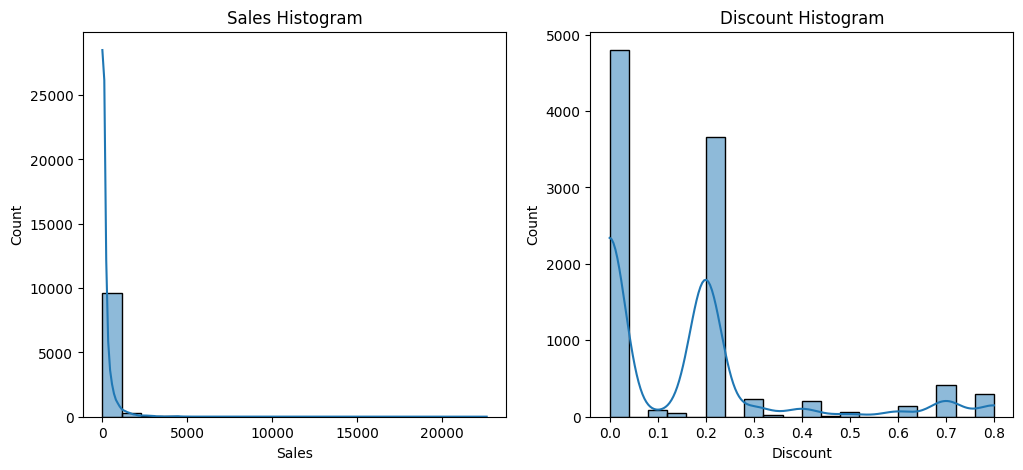

In [87]:
# Test for normality by create Sales and Discount histogram
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.histplot(df5['Sales'], bins=20, kde=True)
plt.title("Sales Histogram")

plt.subplot(1,2,2)
sns.histplot(df5['Discount'], bins=20, kde=True)
plt.title("Discount Histogram")

plt.show()

After using shaphiro wilk test and make histogram for Sales and Discount,<br>
it is concluded that both Sales and Discount are not normally distributed.

In [88]:
# Using Spearman Correlation instead of Pearson Correlation on df5 because Sales or Discount are not normally distributed.

df4_corr = df4.corr(method='spearman').apply(lambda x: round(x,2))
df4_corr

,Sales,Discount
Sales,1.00,-0.06
Discount,-0.06,1.00


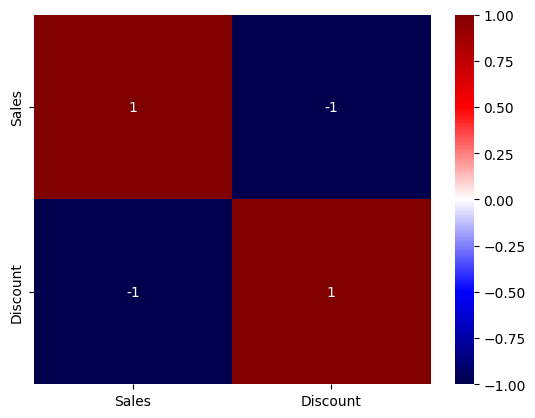

In [89]:
sns.heatmap(df5_corr, annot=True, cmap='seismic', center=0)
plt.show()

**Insight 5:** Sales and Discount has weak negative relations
Recommendation: Analyze Discount Strategy Effectiveness.
Given the weak negative correlation between sales and discounts, it's important to carefully evaluate your discount strategy. Consider conducting further testing to measure the impact of different discount on sales. Monitor customer behavior and purchasing patterns closely during discount periods. Adjust your discount strategy based on the insights gained to strike the right balance between boosting sales and maintaining healthy profit margins.

## **F. Chi-Squared Test for Independence between 5 Countries with the highest sales and 3 Industries with the highest profit**

You have:

1. Countries (categorical variable).
2. Industries (categorical variable).

We want to know if the distribution of sales/profit across industries differs significantly by country.
This is a categorical vs categorical problem → ✅ Chi-Square Test.

1. Filter Data .<br>
    a. Pick top 5 countries with highest sales.<br>
    b. Pick top 3 industries with highest profit.<br>

2. Create a Contingency Table <br>
    A cross-tab (pivot) where rows = countries, columns = industries, values = counts (or aggregated sales/profits).

3. Run Chi-Square Test <br>
    a. Using scipy.stats.chi2_contingency(table) in Python.<br>
    b. Output gives: χ² statistic, p-value, degrees of freedom.

4. Decision Rule <br>
    a. If p <= 0.05 → Reject H₀ → Country & Industry are dependent.<br>
    b. If p > 0.05 → Fail to reject H₀ → No evidence of dependence.        

In [90]:
import pandas as pd
from scipy.stats import chi2_contingency

# Top 5 countries by sales
top_countries = pd.read_sql("""
    SELECT Country, SUM(Sales) AS Total_Sales
    FROM SaaS_Sales
    GROUP BY Country
    ORDER BY Total_Sales DESC
    LIMIT 5;
""", conn)

# Top 3 industries by profit
top_industries = pd.read_sql("""
    SELECT Industry, SUM(Profit) AS Total_Profit
    FROM SaaS_Sales
    GROUP BY Industry
    ORDER BY Total_Profit DESC
    LIMIT 3;
""", conn)

# Contingency table (Country vs Industry, count of orders)
query = f"""
SELECT Country, Industry, COUNT(*) as Orders
FROM SaaS_Sales
WHERE Country IN ({",".join("'" + c + "'" for c in top_countries['Country'])})
  AND Industry IN ({",".join("'" + i + "'" for i in top_industries['Industry'])})
GROUP BY Country, Industry;
"""
contingency_df = pd.read_sql(query, conn)

table = contingency_df.pivot(index="Country", columns="Industry", values="Orders").fillna(0)
table

Industry,Energy,Finance,Manufacturing
Country,,,
Canada,69,129,57
France,45,121,94
Japan,167,207,103
United Kingdom,163,265,137
United States,245,416,226


In [91]:
chi2, p, dof, expected = chi2_contingency(table)

print("Chi-Square Statistic:", chi2)
print("Degrees of Freedom:", dof)
print("p-value:", p)

if p <= 0.05:
    print("Reject H0 → Country and Industry are DEPENDENT")
else:
    print("Fail to reject H0 → No evidence of dependence")


Chi-Square Statistic: 36.91005904573438
Degrees of Freedom: 8
p-value: 1.1955634627355058e-05
Reject H0 → Country and Industry are DEPENDENT


In [97]:
df6 = pd.read_sql("SELECT Country,Sales,Industry,Profit  FROM SaaS_Sales;", conn)

top_countries = df6.groupby("Country")["Sales"].sum().nlargest(5).index
top_industries = df6.groupby("Industry")["Profit"].sum().nlargest(3).index
df_filtered = df6[df6["Country"].isin(top_countries) & df6["Industry"].isin(top_industries)]

import pandas as pd

df6 = pd.crosstab(df_filtered["Country"], df_filtered["Industry"])
print(df6)

Industry        Energy  Finance  Manufacturing
Country                                       
Canada              69      129             57
France              45      121             94
Japan              167      207            103
United Kingdom     163      265            137
United States      245      416            226


In [100]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create Barplot using Country as x axis, Count as y axis and group by Industry from df6
sns.barplot(df6, x='Country', y='Count', hue='Industry')
plt.xticks(ticks=range(len((df6['Country'].unique()))), labels=[label.replace(' ', '\n') for label in df6['Country'].unique()], fontsize=10)  # Adjust x-ticks labels to new rows every whitespace
plt.yticks(fontsize=10)
plt.xlabel(df6.columns[0], fontsize=15)
plt.ylabel(df6.columns[-1], fontsize=15)
plt.title('Countries and Industries Count', fontsize=20)
plt.show()

ValueError: Could not interpret value `Count` for `y`. An entry with this name does not appear in `data`.

From Chi-Squared Test before the result conclude that the two variables are dependent, this conclusion also supported by the barplot above as the occurrences between each unique Countries and Industries are not same, therefore:

**Insight 6:** Country and Industry are dependent
Recommendation: Cross-Reference Country and Industry Strategies.
Since the analysis indicates dependency between the countries with the highest sales and the industries with the highest profit, prioritize aligning your product offerings with the needs of these industries within these countries. Tailor your marketing messages to highlight how your products can specifically benefit the targeted industries in each country. This alignment will likely result in higher customer engagement and conversion rates.

# **After every session download the transformed db for next use.**             

In [ ]:
!ls

SaaS_Company.db  sample_data


In [ ]:
%%sql
SELECT name
FROM sqlite_master
WHERE type='table';

 * sqlite:///SaaS_Company.db
Done.


name
SaaS_Sales


In [101]:
from google.colab import files
files.download('/content/SaaS_Company.db')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>